In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
from dartsort.localize import localize_torch as loc

path_to_dataset = '/mnt/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/'
path2 = '/mnt/data/noah/IBL_data_CEED/dataset/'

In [3]:
#load recording
pathREC = r'/mnt/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/' #session 2
rec = si.read_binary_folder(pathREC)

In [4]:
geom = np.load(path2 + 'geom_sess2.npy')
templates = np.load(path2 + 'templates_sess2.npy')
spikes_idx = np.load(path2 + 'spike_idx_sess2.npy') #spike time, channel location of max channel, neuron id from spike sorting; for each spike
chans_idx = np.load(path2 + 'chan_idx_sess2.npy')

In [5]:
#dirty fix for going out of range:
if spikes_idx[0][-1] != 0:
    spikes_idx[0][-1]=0
    print('change')

downsampled_spikes = spikes_idx[:,::100]

spikes_idx = downsampled_spikes

change


In [6]:
spikes_idx.shape

(3, 12539)

In [7]:
#get amplitudes vector
amplitudes = rec.get_traces()[spikes_idx[0]] #use spike times as index to grab spikes amplitudes
print(amplitudes.shape) #spikes, channels. max amplitude of each spike on each channel

(12539, 384)


In [8]:
positions = spikes_idx[0]

spike_samples = []
for posit in positions:
    spike_samples.append(list(range(posit-43,posit+78)))
spike_samples = [item for sublist in spike_samples for item in sublist] 

In [9]:
channel_indexs = spikes_idx[1] #need to extend each entry by 121 samples to match shape
channels_extended = []
for chan in channel_indexs:
    channels_extended.append([chan]*121)
channels_extended = [item for sublist in channels_extended for item in sublist]

In [10]:
# channels_extended

In [11]:
# multichan = np.asarray(channels_extended)
# multichan2 = multichan
# for i in range(-5,5+1):
#     if i == 0:
#         continue
#     multichan2 = np.vstack((multichan2, multichan+i))
# # multichan2 = np.delete(multichan2, 0, 0)

In [12]:
multichan = np.empty((11, len(channels_extended)), dtype = 'int')
mainchan = np.asanyarray(channels_extended)
for i, offset in enumerate(range(-5,5+1)):
    multichan[i] = mainchan + offset
    # if i == 0:
    #     continue
    # multichan2 = np.vstack((multichan2, multichan+i))
# multichan2 = np.delete(multichan2, 0, 0)

In [13]:
# for i in range(11):
#     print(multichan2[i])
# print('\n')
# for i in range(11):
#     print(multichan[i])

In [14]:
# print(len(multichan.T))

In [15]:
# multichan2.shape

In [16]:
# help(rec.get_traces)

In [17]:
waveforms = rec.get_traces()[spike_samples, multichan]
# waveforms2 = rec.get_traces()[spike_samples, multichan2]

In [18]:
waveformz = rec.get_traces()[spike_samples, channels_extended]
waveformz.shape


(1517219,)

In [19]:
print(waveformz.shape)
new_x = int(waveformz.shape[0]/121)
# # reshape waveform array
waveformz = waveformz.reshape((new_x, 121))
print(waveformz.shape)

(1517219,)
(12539, 121)


In [20]:
print(waveforms.shape)
new_x = int(waveforms.shape[1]/121)
# # reshape waveform array
waveforms = waveforms.reshape((11, new_x, 121)) #need to start using einops lol, reshaping is hard
print(waveforms.shape)

(11, 1517219)
(11, 12539, 121)


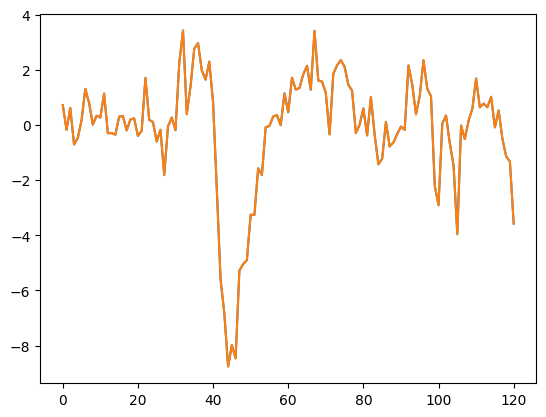

In [21]:
plt.plot(waveformz[0])
plt.plot(waveforms[5,0,:])
plt.show()

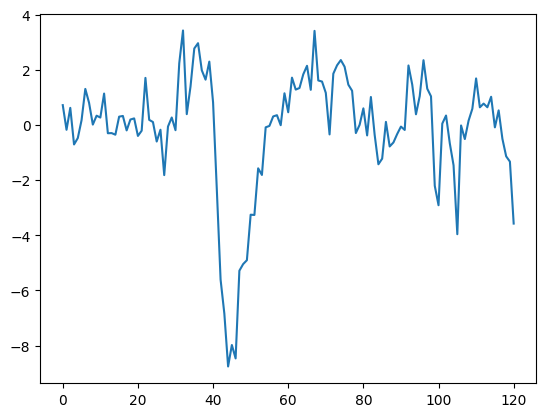

(12539, 11, 121)


In [22]:
# waveforms are now multichannel!
waveforms = np.swapaxes(waveforms, 0, 1)
plt.plot(waveforms[0,5,:])
plt.show()
print(waveforms.shape)

In [23]:
# def normalize_wf(wf):
#     """Normalize waveform for use in cell type experiments.
#     Parameters
#     ----------
#     wf: numpy.ndarray
#         spike that has shape (n_chans, spike_length_samples)
#     Returns
#     -------
#     waveform normalized to the range [0, 1] to retain shape information, but not amplitude information
#     """
#     if len(wf.shape) == 1:
#         _ = wf.shape
#         n_chans = None
#     else:
#         n_chans, _ = wf.shape
#     wf = wf.flatten()
#     if np.max(np.abs(wf), axis=0) != 0:
#         wf /= np.max(np.abs(wf), axis=0)
#     wf = wf.reshape(n_chans, -1) if n_chans is not None else wf
#     return wf

In [24]:
radius = 100 #microns #100 correct
num_spikes_st = 0
num_spikes = -1
main_chan = spikes_idx[1]
subset = None
locs = loc.localize_amplitude_vectors(amplitude_vectors = amplitudes[0:num_spikes], n_channels_subset = subset, geom = geom, main_channels = main_chan[0:num_spikes], radius = radius)


amplitude_vectors.shape=torch.Size([12538, 18])
local_geoms.shape=torch.Size([12538, 18, 2])


In [25]:
z = locs["z_abs"]
x = locs["x"]
pitch = 40

idx_good = np.flatnonzero(np.logical_and(
    np.logical_and(x > geom[:, 0].min()-pitch, x < geom[:, 0].max()+pitch),
    np.logical_and(z > geom.min()-pitch, z < geom.max()+pitch)))

x = x[idx_good]
z = z[idx_good]
index = spikes_idx[2][idx_good]
waveforms = waveforms[idx_good, :, :]
amplitudes = amplitudes[idx_good, :]

In [26]:
import colorcet as cc
def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
# ccolors = cc.glasbey[:31]
ccolors = cc.glasbey[:50]

cols = [get_ccolor(idx) for idx in index]

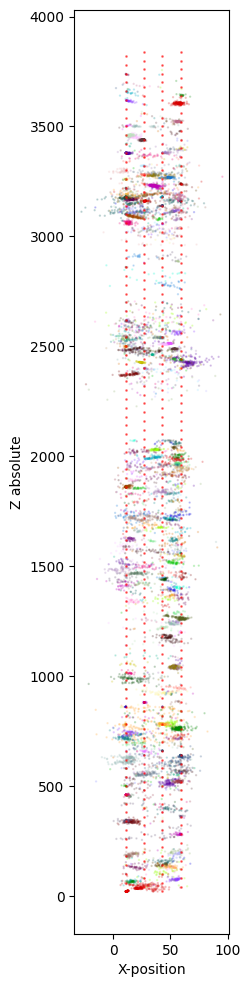

In [27]:
plt.figure(figsize=(2,12)) #2,12 is better tbh

plt.scatter(x, z, alpha=0.2, s = 0.5, c = cols) #coloured by neuron id, adds nothing but confirms things work!
plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
plt.xlabel('X-position')
plt.ylabel('Z absolute')
#2x12
plt.show()

In [28]:
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D

2023-12-07 15:36:21.914416: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 15:36:21.944900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 15:36:21.944943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 15:36:21.945712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 15:36:21.950506: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 15:36:21.950966: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [29]:
fc_spikesorting_ckpt_dir = '/home/noah/code/ceed_models/spikesort'

fc_spikesorting_ceed_5d = CEED(num_extra_chans=5, out_dim=5, proj_dim=5, gpu=0, old_ckpt=True)
fc_spikesorting_ceed_5d.load(fc_spikesorting_ckpt_dir)

Using projector; batchnorm False with depth 3; hidden_dim=512
loading from previous checkpoint:  /home/noah/code/ceed_models/spikesort


In [30]:
print(waveforms.shape)
batch = 1
cells = waveforms.shape[0]
timepoints = waveforms.shape[2]
channels = waveforms.shape[1]

(12433, 11, 121)


In [31]:
waveforms = np.asarray(waveforms.squeeze())

In [32]:
# waveforms = torch.from_numpy(waveforms.astype('float32')) #must be float32?
waveforms = waveforms.reshape(batch, int(cells/batch), channels, timepoints)
# waveforms = waveforms.to('cuda') 

#put on the gpu in the inference loop?
#https://discuss.pytorch.org/t/dataset-location-runtimeerror-caught-runtimeerror-in-dataloader-worker-process-0/156842

# print(waveforms.shape, waveforms.device)

In [33]:
embeddings_all = []
with torch.no_grad():
    for spike in tqdm(waveforms):
        # data = torch.unsqueeze(spike, dim=-1)
        # spike.to('cuda')
        feature = fc_spikesorting_ceed_5d.transform(spike) #returns a np array
        embeddings_all.append(feature)
# embeddings_all = torch.concatenate(embeddings_all).to('cpu').detach().squeeze().numpy()
embeddings_all = np.asarray(embeddings_all).squeeze()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


In [35]:
waveforms = waveforms.squeeze()

In [37]:
print(embeddings_all.shape)
print(waveforms.shape)

(12433, 5)
(12433, 11, 121)


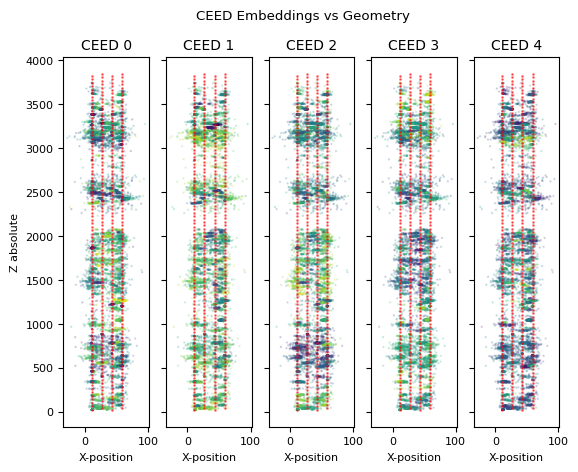

In [38]:
def qplot(i):
    ax[i].scatter(x, z, alpha=0.2, s = 0.5, c = embeddings_all[:,i])
    ax[i].scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
    ax[i].set_xlabel('X-position')
    if i == 0:
        ax[i].set_ylabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)
    # ax[i].set_ylim(0,1000)
    # ax[i].axis('equal')
    # ax[i].set_xlim(-1,1)

fig, ax = plt.subplots(1,5, sharey = True)
fig.suptitle('CEED Embeddings vs Geometry', fontsize='large')

for i in range(5):
    qplot(i)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()

In [39]:
import scipy.signal as signal
def align_spikes(wfs):
# input: waveforms of shape NxT
# upsample the waveform in time first for finer scale alignment
# then downsample the waveform to its original shape
    N, T = np.shape(wfs)
    upsampled_wfs = signal.resample(wfs, 10*T, axis = 1)
    aligned_wfs = np.zeros([N, 2500]) 
    peak_idx = 1050 # a value that is larger than all peak index values
    peak_point = np.argmax(np.absolute(upsampled_wfs), axis =1)    
    shift = peak_idx - peak_point

    for i in range(len(shift)):
        try:
            aligned_wfs[i, shift[i]:(shift[i] + 10*T)] = upsampled_wfs[i,:]
        except:
            # print(i)
            pass
        
    return  signal.resample(aligned_wfs[:,630:(630+1210 + 1)], T, axis = 1)

# aligned_wfs = align_spikes(waveforms)

In [40]:
# from dartsort.transform import single_channel_denoiser as scd
path = r'/home/noah/code/dartsort/pretrained/single_chan_denoiser.pt'
# dns = scd.SingleChannelDenoiser()
# dns.load(path)

from spike_psvae import denoise

dn = denoise.SingleChanDenoiser().load(path)

# wfs_denoised = dn(torch.FloatTensor(aligned_wfs).reshape(-1, 121)).reshape(aligned_wfs.shape).detach().numpy()

In [41]:
waveforms[-1,:,5,:].shape

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [42]:
#find ptp amps:
ptp = np.asarray([np.ptp(wave) for wave in waveforms[:,5,:]]) #note that this is not denoised!

In [43]:
spike_sorting_features = np.empty((embeddings_all.shape[0], embeddings_all.shape[1]+3), dtype='float32')

for i, ceed_features in enumerate(embeddings_all):
    spike_sorting_features[i] = np.append(ceed_features, [x[i], z[i], ptp[i]])
#shape == ceed1, ceed2, ceed3, ceed4, ceed5, x, z, ptp for every spike

In [44]:
spike_sorting_features[0]

array([ 2.41734192e-01,  1.17536284e-01, -5.52073538e-01, -3.22628379e-01,
        7.20330238e-01,  3.48158035e+01,  3.09147656e+03,  1.21819630e+01],
      dtype=float32)

In [45]:
#add location info:

# spike_sorting_features = list(zip(embeddings_all.tolist(), z, x))
# spike_sorting_features = list(map(list, zip(embeddings_all.tolist(), z, x)))

In [46]:
# spike_sorting_features[1]

In [47]:
# def flatten(l):
#     return [item for sublist in l for item in sublist if isinstance(l, list)]

In [48]:
# spike_sorting_features = [flatten(feature) for feature in spike_sorting_features]

In [49]:
spike_sorting_features.shape

(12433, 8)

## Cluster this data

In [60]:
original_features = spike_sorting_features[:,5::] #x, y , ptp

In [61]:
original_features[0]

array([  34.815804, 3091.4766  ,   12.181963], dtype=float32)

In [52]:
#best clustering is to use hdbscan

In [53]:
import hdbscan

In [76]:
# create list of features (scaled)

# scale is /stddev

# take distrubutions of ceed features -try to make gaussian

# scale everything to std dev of x

#note that the -1 label is for outliers

In [69]:
# lets scale features:
std_dev_x = np.std(original_features[:, 0])
print(std_dev_x)
original_features = original_features/std_dev_x
original_features[0]

0.01667112


array([  1.846733 , 163.98105  ,   0.6461673], dtype=float32)

In [71]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(original_features)

HDBSCAN()

In [75]:
len(np.unique(clusterer.labels_))

252

In [82]:
#outlier percentage
( list(clusterer.labels_).count(-1) / len(clusterer.labels_) ) * 100

23.952384782433846

In [ ]:
# plot clusters:

